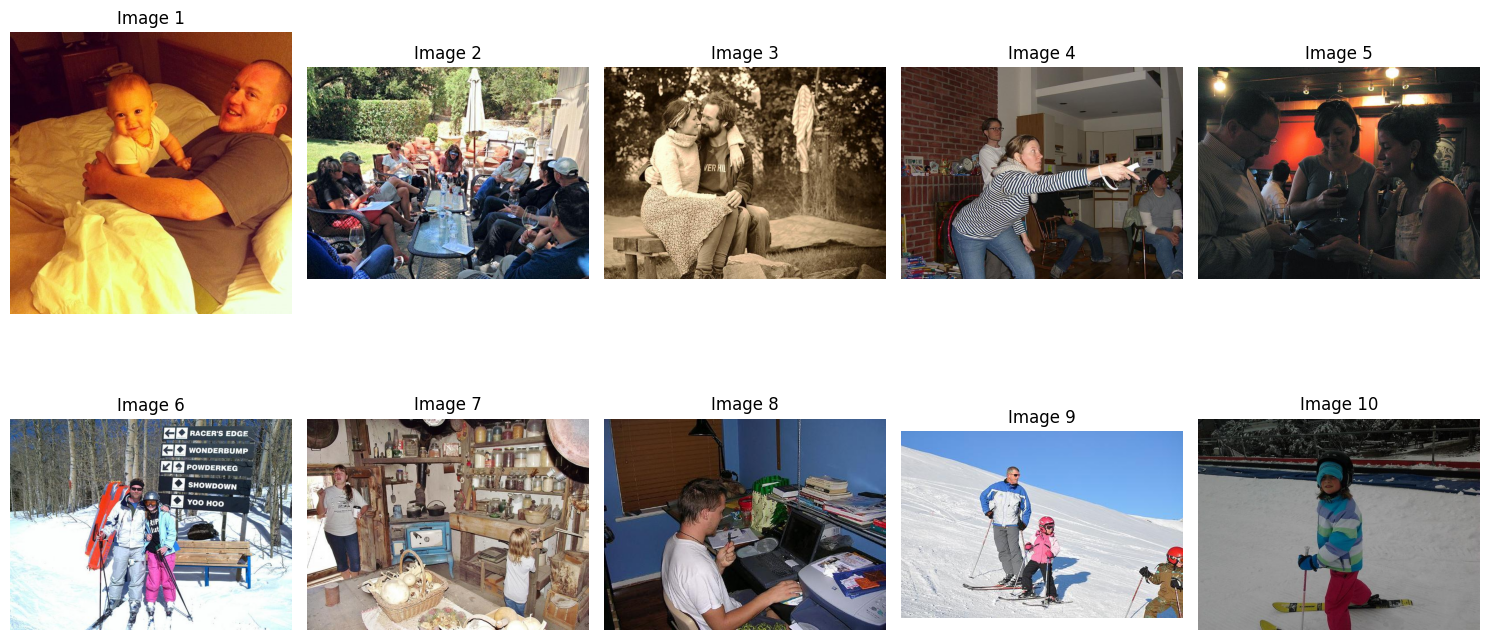

In [10]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your dataset folder
dataset_folder = "labeled_images"

# Get a list of all the image files in the dataset folder
image_files = ['Affection', 'Anger', 'Annoyance', 'Anticipation', 'Aversion', 'Confidence','Confusion', 'Disapproval', 'Disconnection',
              'Disquietment', 'Embarrassment', 'Engagement', 'Esteem', 'Excitement', 'Fatigue', 'Fear',
              'Happiness', 'Pain', 'Peace', 'Pleasure', 'Sadness', 'Sensitivity', 'Suffering', 'Surprise', 'Sympathy', 'Yearning']
for emotion_folder in os.listdir(dataset_folder):
    emotion_path = os.path.join(dataset_folder, emotion_folder)
    if os.path.isdir(emotion_path):
        for file in os.listdir(emotion_path):
            if file.endswith(".jpg") or file.endswith(".png"):
                image_files.append(os.path.join(emotion_path, file))


plt.figure(figsize=(15, 8))  # Adjust figure size for better display
for i in range(10):
    random_image_path = random.choice(image_files)
    image = Image.open(random_image_path)
    plt.subplot(2, 5, i+1)  # 2 rows, 5 columns, i+1 index
    plt.imshow(image)
    plt.title(f"Image {i+1}")  # Add title with image number
    plt.axis('off')  # Turn off axis
plt.tight_layout()  # Adjust layout
plt.show()

In [11]:
import os
import random
import shutil

# Define the path to your dataset folder
dataset_folder = "labeled_images"

# Define the paths for the train and test folders
train_folder = "train"
test_folder = "test"

# Create train and test folders if they don't exist
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Get a list of all the image files and their corresponding labels in the dataset folder
image_labels = []
for emotion_folder in os.listdir(dataset_folder):
    emotion_path = os.path.join(dataset_folder, emotion_folder)
    if os.path.isdir(emotion_path):
        for file in os.listdir(emotion_path):
            if file.endswith(".jpg") or file.endswith(".png"):
                image_path = os.path.join(emotion_path, file)
                image_labels.append((image_path, emotion_folder))

# Shuffle the image labels to randomly distribute them into train and test sets
random.shuffle(image_labels)

# Split ratio for train-test (80-20 split)
split_ratio = 0.8
train_size = int(len(image_labels) * split_ratio)

# Move images to train folder
for image_path, label in image_labels[:train_size]:
    destination = os.path.join(train_folder, label)
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.copy(image_path, destination)

# Move images to test folder
for image_path, label in image_labels[train_size:]:
    destination = os.path.join(test_folder, label)
    if not os.path.exists(destination):
        os.makedirs(destination)
    shutil.copy(image_path, destination)

print("Data split and folders created successfully.")


Data split and folders created successfully.


In [12]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import LSTM

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)




Tensorflow version: 2.14.0


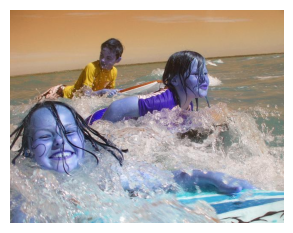

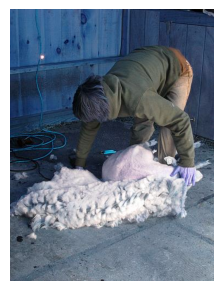

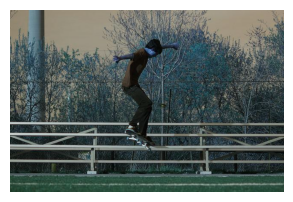

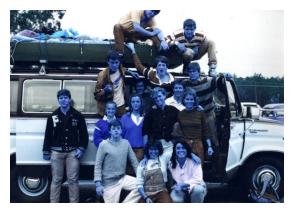

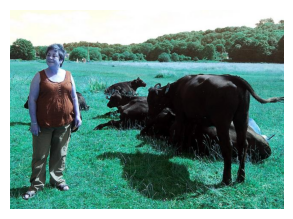

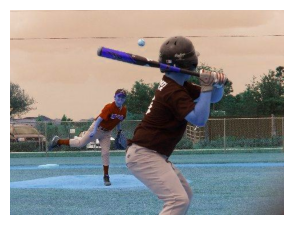

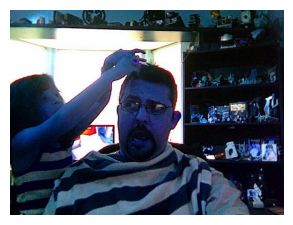

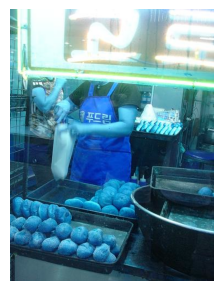

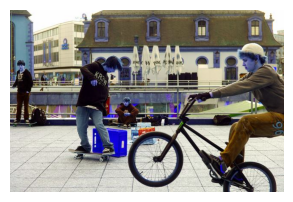

In [13]:
images = glob("train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

In [14]:
img_size =224
batch_size= 64
datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/" ,
                                                   target_size = (img_size,img_size),
                                                    color_mode = "grayscale",
                                                    batch_size =batch_size,
                                                    class_mode = "categorical" ,
                                                    shuffle =True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)
                                                    

Found 18504 images belonging to 26 classes.
Found 4627 images belonging to 26 classes.


In [10]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

class FaceEncodingModule(nn.Module):
    def __init__(self):
        super(FaceEncodingModule, self).__init__()
        self.conv1 = nn.Conv3d(3, 32, kernel_size=(3, 3, 3), padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv3 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv4 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1)
        self.bn4 = nn.BatchNorm3d(256)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=1)
        self.bn5 = nn.BatchNorm3d(256)
        self.pool5 = nn.MaxPool3d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool4(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool5(x)
        # Spatial average pooling
        x = torch.mean(x, dim=(2, 3, 4))
        return x



In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContextEncodingStream(nn.Module):
    def __init__(self, input_channels):
        super(ContextEncodingStream, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x

class AttentionInferenceModule(nn.Module):
    def __init__(self, input_channels):
        super(AttentionInferenceModule, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv3d(input_channels, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 1, kernel_size=3, padding=1),
            nn.BatchNorm3d(1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x

class ContextAttentionModule(nn.Module):
    def __init__(self, input_channels):
        super(ContextAttentionModule, self).__init__()
        self.context_stream = ContextEncodingStream(input_channels)
        self.attention_inference = AttentionInferenceModule(256)

    def forward(self, x):
        context_features = self.context_stream(x)
        attention = self.attention_inference(context_features)
        attention = attention.squeeze(1)  # Remove singleton dimension
        attention = F.softmax(attention, dim=1)  # Apply softmax along the channel dimension
        context_attention = attention * context_features
        context_attention = torch.mean(context_attention, dim=(2, 3, 4))
        return context_attention

